## 1. Import

In [8]:
# 1. Bibliotheken importieren
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from model import HockeyActionModel   # Modell aus model.py
from dataloader import HockeyDataset  # DataLoader aus dataloader.py
import os 
import matplotlib.pyplot as plt

## 2. Device & Hyperparameter


In [9]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA RTX A5000 Laptop GPU


In [10]:
# 2. Device auswählen
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Benutze Gerät: {device}")

Benutze Gerät: cuda


In [11]:
def custom_collate(batch):
    videos = torch.stack([item[0] for item in batch])  # [B, T, 3, 224, 224]
    labels = torch.tensor([item[1] for item in batch])  # [B]
    return videos, labels


In [12]:
# Konfiguration
batch_size = 4
num_epochs = 30
frames_per_clip = 100

## 3. Dataset & Dataloader

In [13]:
# Trainings-Transform mit Augmentation (nur fürs Training)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),            # zufälliges Spiegeln
    transforms.RandomRotation(degrees=5),         # leichte Drehung
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Farbabweichung
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Val-Transform ohne Augmentation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Gesamtdataset laden (Train + Val gemeinsam)
full_dataset = HockeyDataset('labels.csv', 'frames', transform=train_transform, frames_per_clip=frames_per_clip)

# Split in 80% Training, 20% Validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Für Val-Set das Transform austauschen (ohne Augmentation)
val_dataset.dataset.transform = val_transform

# Dataloader für Training und Validierung
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

## 4. Model + Loss + Optimizer 

In [14]:
model = HockeyActionModel().to(device)                      # Modell auf GPU/CPU laden
criterion = nn.CrossEntropyLoss()                           # Verlustfunktion für Klassifikation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimierer

# Lernraten-Scheduler: reduziert LR, wenn val_loss stagniert
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)


c:\Users\hp\anaconda3\envs\picture\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hp\anaconda3\envs\picture\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\hp\anaconda3\envs\picture\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


## 5. Trainingsloop

In [15]:
best_val_loss = float('inf')  # Bester bisher gesehener Val-Loss
patience = 5                   # Geduld für Early Stopping
counter = 0                    # zählt Epochen ohne Verbesserung

# Zum Plotten der Performance
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()  # Trainingsmodus aktivieren
    running_loss, correct, total = 0.0, 0, 0

    for frames, labels in train_loader:
        frames, labels = frames.to(device), labels.to(device)

        outputs = model(frames)                      # Vorhersage
        loss = criterion(outputs, labels)            # Verlust berechnen

        optimizer.zero_grad()                        # Gradienten zurücksetzen
        loss.backward()                              # Gradienten berechnen
        optimizer.step()                             # Gewichte aktualisieren

        running_loss += loss.item()                  # Verlust aufsummieren
        _, predicted = torch.max(outputs, 1)         # Vorhersageklasse ermitteln
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)    # Durchschnittsverlust Training
    train_acc = 100 * correct / total                # Genauigkeit Training
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validierung
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for val_frames, val_labels in val_loader:
            val_frames, val_labels = val_frames.to(device), val_labels.to(device)

            val_outputs = model(val_frames)
            loss = criterion(val_outputs, val_labels)

            val_loss += loss.item()
            _, predicted = torch.max(val_outputs, 1)
            correct += (predicted == val_labels).sum().item()
            total += val_labels.size(0)

    val_loss /= len(val_loader)                      # Durchschnittsverlust Val
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Acc {train_acc:.2f}% | Val Loss {val_loss:.4f}, Acc {val_acc:.2f}%")

    scheduler.step(val_loss)                         # Scheduler updaten

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # Modell speichern
    else:
        counter += 1
        print(f"Early Stopping Counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1: Train Loss 1.3566, Acc 25.93% | Val Loss 1.2997, Acc 33.33%
Epoch 2: Train Loss 1.0635, Acc 58.02% | Val Loss 1.5004, Acc 57.14%
Early Stopping Counter: 1/5
Epoch 3: Train Loss 0.8208, Acc 67.90% | Val Loss 1.1968, Acc 61.90%
Epoch 4: Train Loss 0.7018, Acc 71.60% | Val Loss 1.3894, Acc 42.86%
Early Stopping Counter: 1/5
Epoch 5: Train Loss 0.4779, Acc 81.48% | Val Loss 2.6225, Acc 38.10%
Early Stopping Counter: 2/5
Epoch 6: Train Loss 0.7029, Acc 75.31% | Val Loss 1.6542, Acc 52.38%
Early Stopping Counter: 3/5
Epoch 7: Train Loss 0.6710, Acc 80.25% | Val Loss 1.8578, Acc 47.62%
Early Stopping Counter: 4/5
Epoch 8: Train Loss 0.4438, Acc 88.89% | Val Loss 1.4932, Acc 66.67%
Early Stopping Counter: 5/5
Early stopping triggered.


## 6. Plot Training und Validation

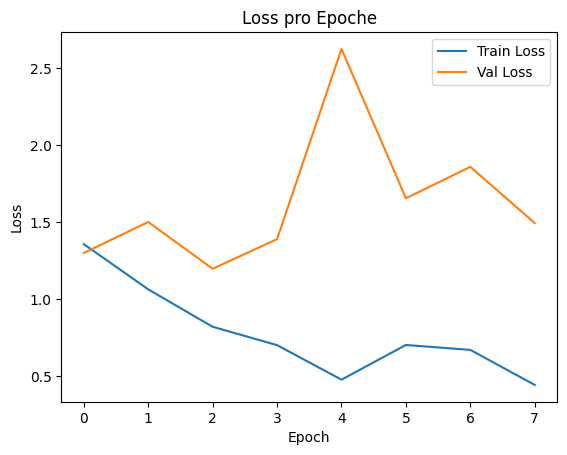

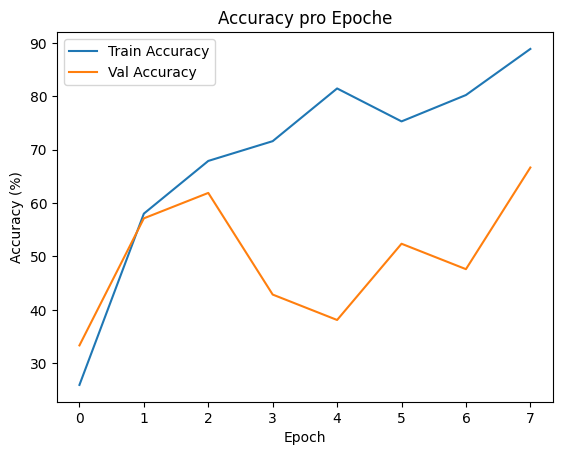

In [16]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss pro Epoche')
plt.show()

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy pro Epoche')
plt.show()

## 6. Modell speichern

In [17]:
# os.makedirs('models', exist_ok=True)
# torch.save(model.state_dict(), 'models/hockey_action_model.pth')
# print("✅ Modell erfolgreich gespeichert.")
